# AlphaZero 五子棋训练分析

本notebook对训练日志进行全面分析，提取关键信息并进行可视化，帮助理解训练过程和模型性能。

In [1]:
# 解析日志文件
log_path = '7x5_train_log_20250505_153458.txt'  # 请根据实际文件路径调整

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from scipy import stats
import os

# 设置可视化风格
plt.style.use('ggplot')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [3]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os

# 1. 检查并设置中文字体
def set_chinese_font():
    # 尝试使用系统自带的中文字体
    font_paths = [
        'C:/Windows/Fonts/simhei.ttf',  # 黑体
        'C:/Windows/Fonts/msyh.ttc',    # 微软雅黑
        'C:/Windows/Fonts/simkai.ttf',  # 楷体
    ]
    
    # 查找第一个可用的中文字体
    for font_path in font_paths:
        if os.path.exists(font_path):
            font_prop = fm.FontProperties(fname=font_path)
            plt.rcParams['font.sans-serif'] = [font_prop.get_name()]
            plt.rcParams['axes.unicode_minus'] = False
            return True
    
    # 如果没有找到系统字体，尝试下载并使用临时字体
    try:
        import urllib.request
        print("正在下载中文字体...")
        urllib.request.urlretrieve(
            "https://github.com/googlefonts/noto-cjk/raw/main/Sans/OTF/SimplifiedChinese/NotoSansCJKsc-Regular.otf",
            "NotoSansCJKsc-Regular.otf")
        font_prop = fm.FontProperties(fname="NotoSansCJKsc-Regular.otf")
        plt.rcParams['font.sans-serif'] = [font_prop.get_name()]
        plt.rcParams['axes.unicode_minus'] = False
        return True
    except:
        print("无法自动下载中文字体，请手动安装")
        return False

# 设置中文字体
set_chinese_font()



True

## 1. 日志数据解析

从训练日志中提取两类关键信息：
1. 每批次训练详情（损失、KL散度等）
2. 定期评估结果（胜率等）

In [4]:
import re
import pandas as pd

def parse_training_log(log_path):
    """解析训练日志文件，提取训练数据和评估数据"""
    
    # 初始化用于存储提取数据的列表
    train_data = []
    eval_data = []
    
    # 解析的正则表达式模式
    batch_pattern = re.compile(r'训练批次: (\d+), 当前对局长度: (\d+)')
    metrics_pattern = re.compile(r'kl:([\d.]+), lr_multiplier:([\d.]+), loss:([\d.]+), entropy:([\d.]+), explained_var_old:([\d.-]+), explained_var_new:([\d.-]+)')
    eval_batch_pattern = re.compile(r'\[评估结果\]')  # 固定匹配评估开始标记
    eval_result_pattern = re.compile(r'胜:(\d+), 负:(\d+), 平:(\d+)，胜率:([\d.]+)') #样例内容：  [评估结果]胜:0, 负:20, 平:0，胜率:0.000

    current_batch = None
    current_episode_len = None
    last_logged_batch = None  # 新增：用于记录最近一次训练批次
    
    with open(log_path, 'r', encoding='utf-8') as f:
        for line in f:
            # 匹配训练批次和对局长度
            batch_match = batch_pattern.search(line)
            if batch_match:
                current_batch = int(batch_match.group(1))
                current_episode_len = int(batch_match.group(2))
                continue
            
            # 匹配训练指标数据
            metrics_match = metrics_pattern.search(line)
            if metrics_match and current_batch is not None:
                kl = float(metrics_match.group(1))
                lr_mult = float(metrics_match.group(2))
                loss = float(metrics_match.group(3))
                entropy = float(metrics_match.group(4))
                exp_var_old = float(metrics_match.group(5))
                exp_var_new = float(metrics_match.group(6))
                
                train_data.append({
                    'batch': current_batch,
                    'episode_len': current_episode_len,
                    'kl': kl,
                    'lr_multiplier': lr_mult,
                    'loss': loss,
                    'entropy': entropy,
                    'explained_var_old': exp_var_old,
                    'explained_var_new': exp_var_new
                })
                
                current_batch = None
                current_episode_len = None
                continue
            
            # 匹配评估开始标记
            eval_batch_match = eval_batch_pattern.search(line)
            if eval_batch_match and train_data:
                # 取上一次的训练批次作为本次评估批次（即评估的是该批次后模型）
                last_logged_batch = train_data[-1]['batch']
                #continue
                
            # 匹配评估结果
            eval_result_match = eval_result_pattern.search(line)
            if eval_result_match and last_logged_batch is not None:
                wins = int(eval_result_match.group(1))
                losses = int(eval_result_match.group(2))
                draws = int(eval_result_match.group(3))
                win_ratio = float(eval_result_match.group(4))
                
                eval_data.append({
                    'eval_batch': last_logged_batch,  # 使用最后一次记录的训练批次作为评估批次
                    'wins': wins,
                    'losses': losses,
                    'draws': draws,
                    'win_ratio': win_ratio,
                    'total_games': wins + losses + draws
                })
                
                last_logged_batch = None  # 重置以便下次重新判断
    
    train_df = pd.DataFrame(train_data)
    eval_df = pd.DataFrame(eval_data)
    
    return train_df, eval_df

# 示例调用
# 解析日志文件
log_path = '7x5_train_log_20250505_153458.txt'  # 请根据实际文件路径调整
train_df, eval_df = parse_training_log(log_path)

# 保存为CSV文件以便未来使用
train_df.to_csv('training_metrics.csv', index=False)
eval_df.to_csv('evaluation_metrics.csv', index=False) #空的

# 显示提取的训练数据样例
print(f"共提取 {len(train_df)} 条训练数据记录")
train_df.head()

共提取 2000 条训练数据记录


,batch,episode_len,kl,lr_multiplier,loss,entropy,explained_var_old,explained_var_new
0,1,43,0.00024,1.500,4.8366,3.8905,0.001,0.080
1,2,30,0.00994,2.250,4.7308,3.8834,0.045,0.235
2,3,25,0.01108,2.250,4.8066,3.8568,0.108,0.055
3,4,27,0.01098,2.250,4.7856,3.8785,0.053,0.113
4,5,25,0.00100,3.375,4.6434,3.8713,0.096,0.097


In [5]:
# 显示提取的评估数据
print(f"共提取 {len(eval_df)} 条评估数据记录")
eval_df.head()

共提取 40 条评估数据记录


,eval_batch,wins,losses,draws,win_ratio,total_games
0,50,0,20,0,0.00,20
1,100,3,17,0,0.15,20
2,150,5,13,2,0.30,20
3,200,10,10,0,0.50,20
4,250,8,10,2,0.45,20


## 2. 基本训练指标分析

分析训练过程中的关键指标变化趋势，包括损失、熵、KL散度等。

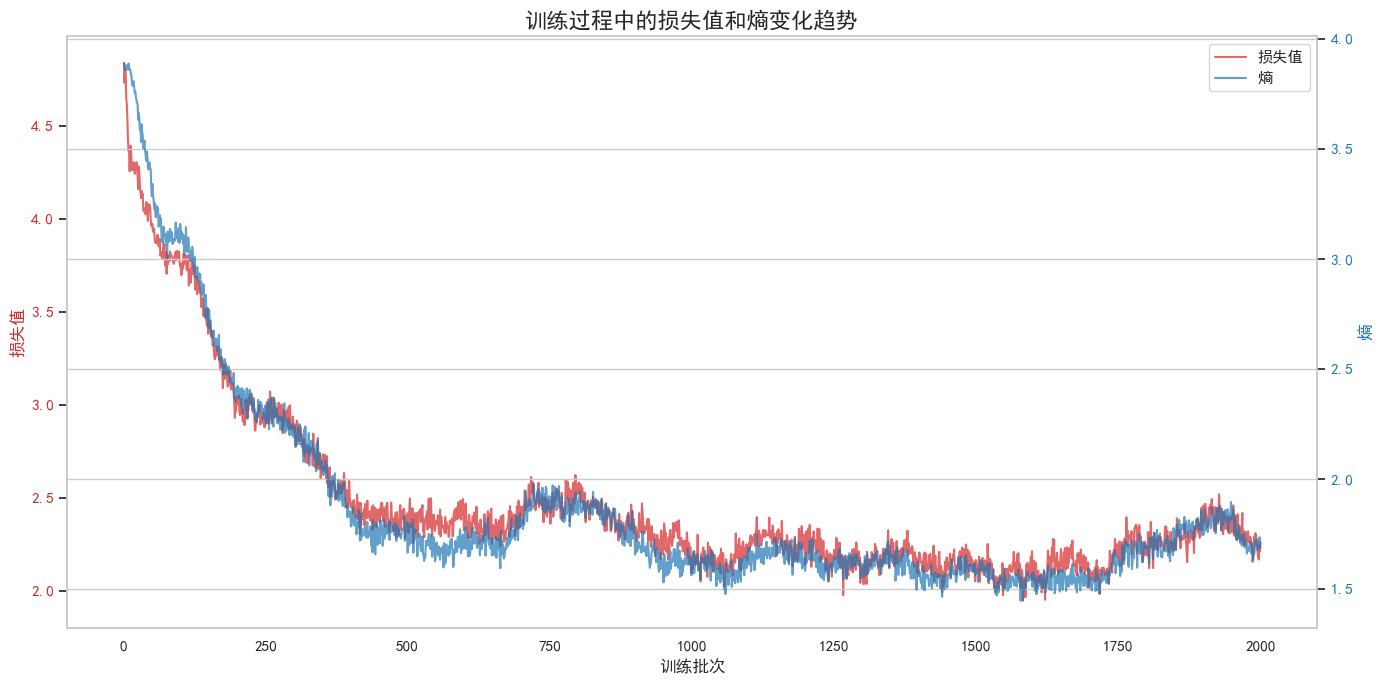

In [6]:
# 训练损失和熵趋势图
fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:red'
ax1.set_xlabel('训练批次')
ax1.set_ylabel('损失值', color=color)
ax1.plot(train_df['batch'], train_df['loss'], color=color, marker='', linestyle='-', alpha=0.7, label='损失值')
ax1.tick_params(axis='y', labelcolor=color)

# 创建第二个Y轴用于显示熵
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('熵', color=color)  
ax2.plot(train_df['batch'], train_df['entropy'], color=color, marker='', linestyle='-', alpha=0.7, label='熵')
ax2.tick_params(axis='y', labelcolor=color)

# 添加网格线和标题
ax1.grid(False)
plt.title('训练过程中的损失值和熵变化趋势', fontsize=16)

# 添加图例
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.savefig('loss_entropy_trend.png', dpi=300, bbox_inches='tight')
plt.show()

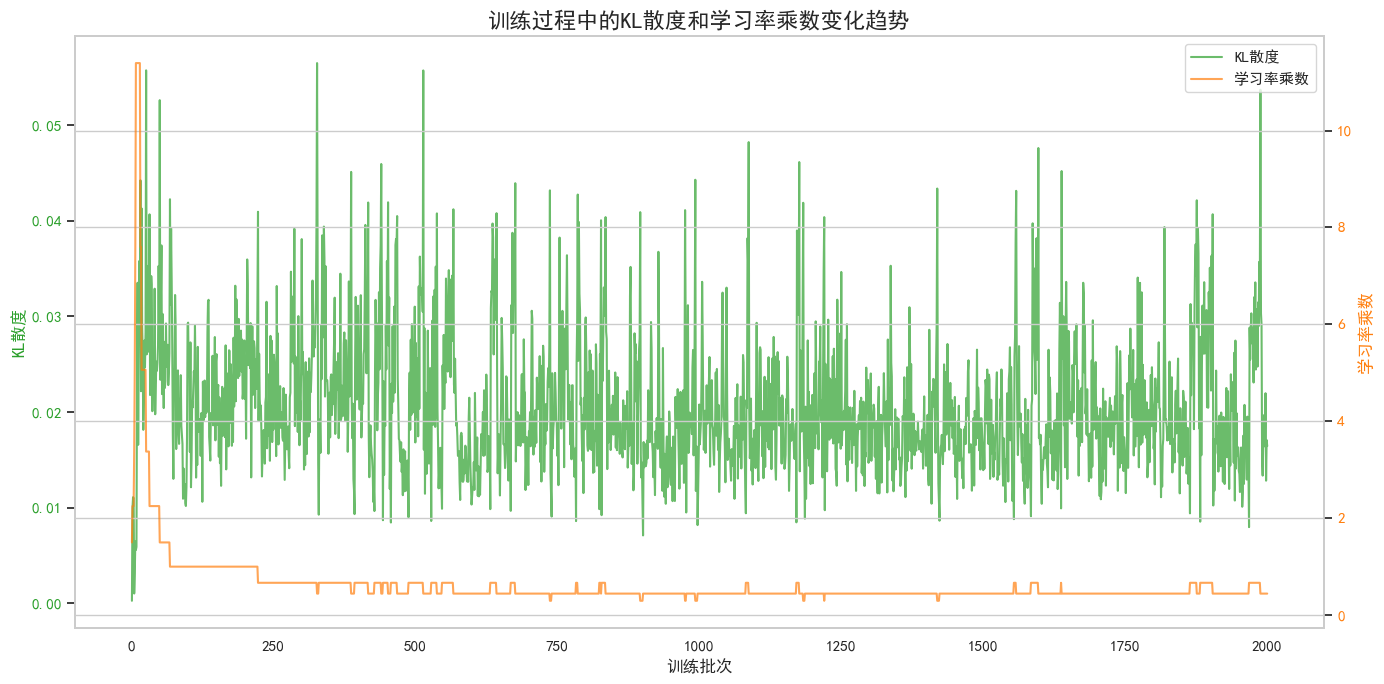

In [7]:
# KL散度和学习率乘数趋势图
fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:green'
ax1.set_xlabel('训练批次')
ax1.set_ylabel('KL散度', color=color)
ax1.plot(train_df['batch'], train_df['kl'], color=color, marker='', linestyle='-', alpha=0.7, label='KL散度')
ax1.tick_params(axis='y', labelcolor=color)

# 创建第二个Y轴用于显示学习率乘数
ax2 = ax1.twinx()  
color = 'tab:orange'
ax2.set_ylabel('学习率乘数', color=color)  
ax2.plot(train_df['batch'], train_df['lr_multiplier'], color=color, marker='', linestyle='-', alpha=0.7, label='学习率乘数')
ax2.tick_params(axis='y', labelcolor=color)

# 添加网格线和标题
ax1.grid(False)
plt.title('训练过程中的KL散度和学习率乘数变化趋势', fontsize=16)

# 添加图例
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.savefig('kl_lr_trend.png', dpi=300, bbox_inches='tight')
plt.show()

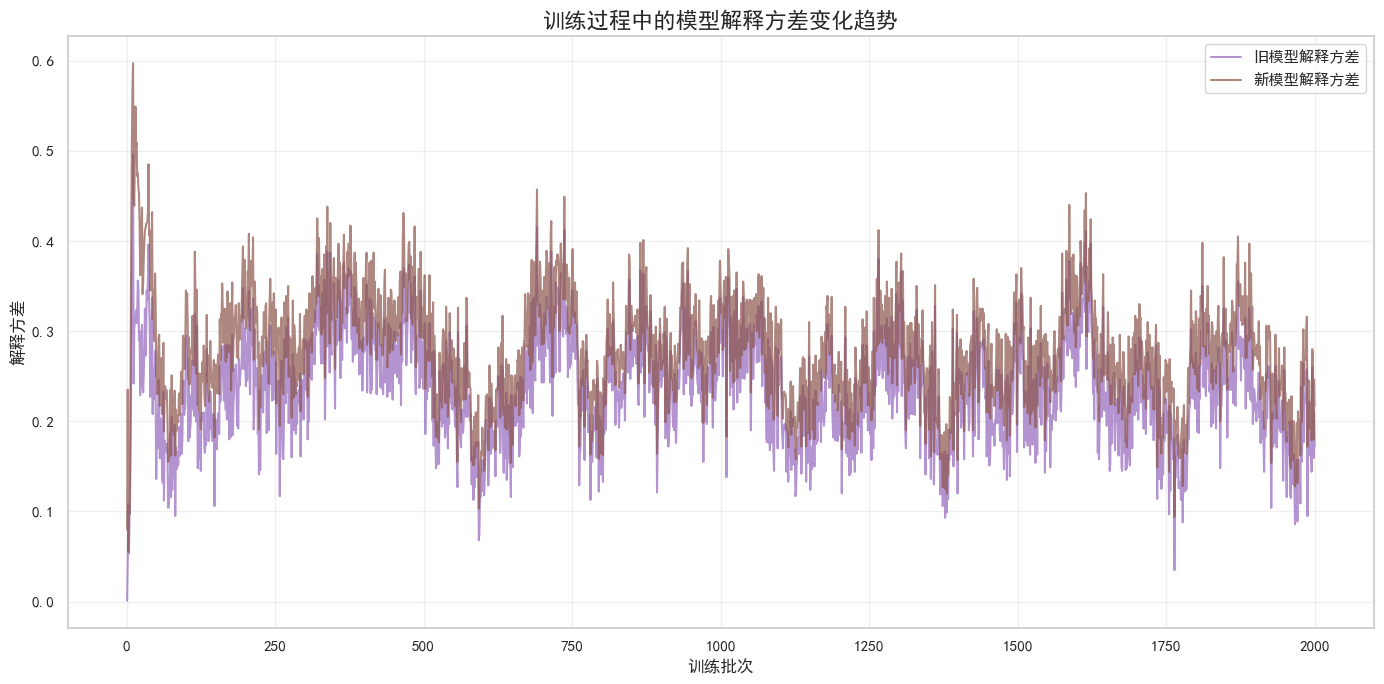

In [8]:
# 解释方差变化趋势
plt.figure(figsize=(14, 7))

plt.plot(train_df['batch'], train_df['explained_var_old'], color='tab:purple', marker='', linestyle='-', alpha=0.7, label='旧模型解释方差')
plt.plot(train_df['batch'], train_df['explained_var_new'], color='tab:brown', marker='', linestyle='-', alpha=0.7, label='新模型解释方差')

plt.xlabel('训练批次')
plt.ylabel('解释方差')
plt.title('训练过程中的模型解释方差变化趋势', fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.savefig('explained_var_trend.png', dpi=300, bbox_inches='tight')
plt.show()

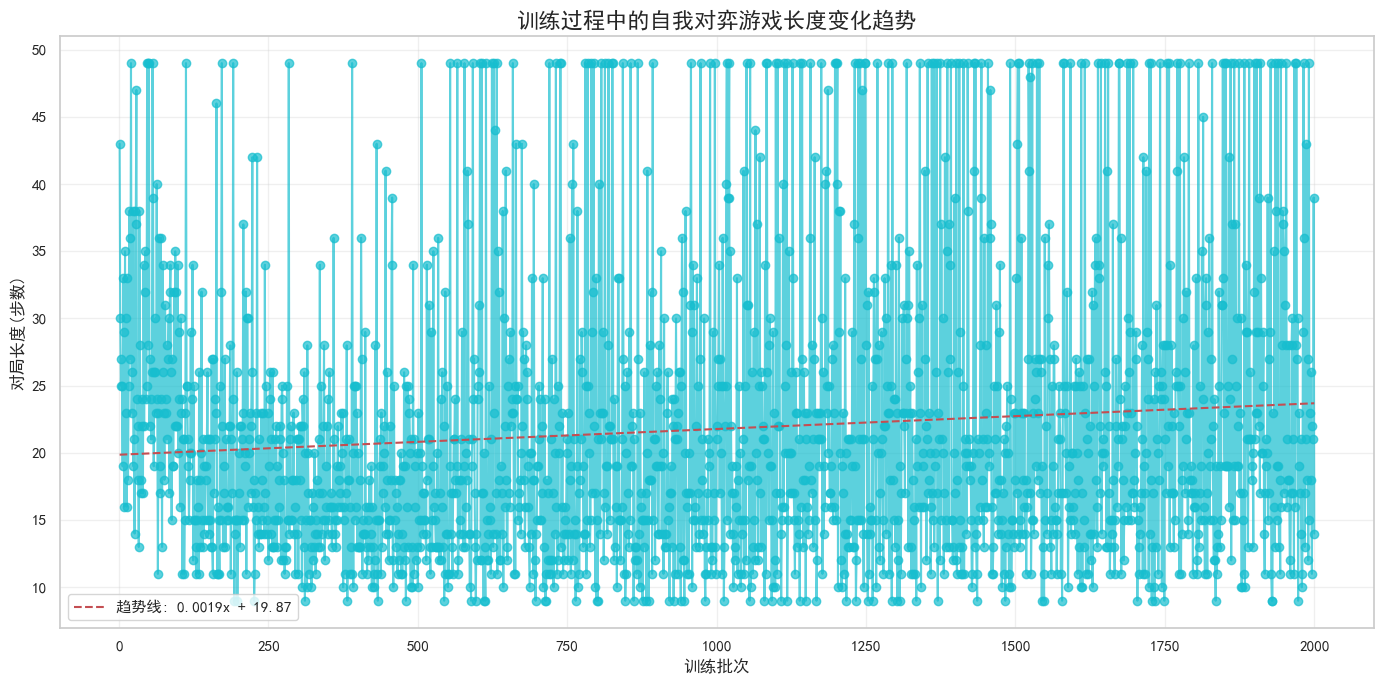

In [9]:
# 自我对弈游戏长度趋势
plt.figure(figsize=(14, 7))

plt.plot(train_df['batch'], train_df['episode_len'], color='tab:cyan', marker='o', linestyle='-', alpha=0.7)

plt.xlabel('训练批次')
plt.ylabel('对局长度(步数)')
plt.title('训练过程中的自我对弈游戏长度变化趋势', fontsize=16)
plt.grid(True, alpha=0.3)

# 添加趋势线
z = np.polyfit(train_df['batch'], train_df['episode_len'], 1)
p = np.poly1d(z)
plt.plot(train_df['batch'], p(train_df['batch']), "r--", label=f"趋势线: {z[0]:.4f}x + {z[1]:.2f}")
plt.legend()

plt.tight_layout()
plt.savefig('episode_length_trend.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. 模型评估分析

分析模型定期评估结果，包括胜率趋势、胜负结果分布等。

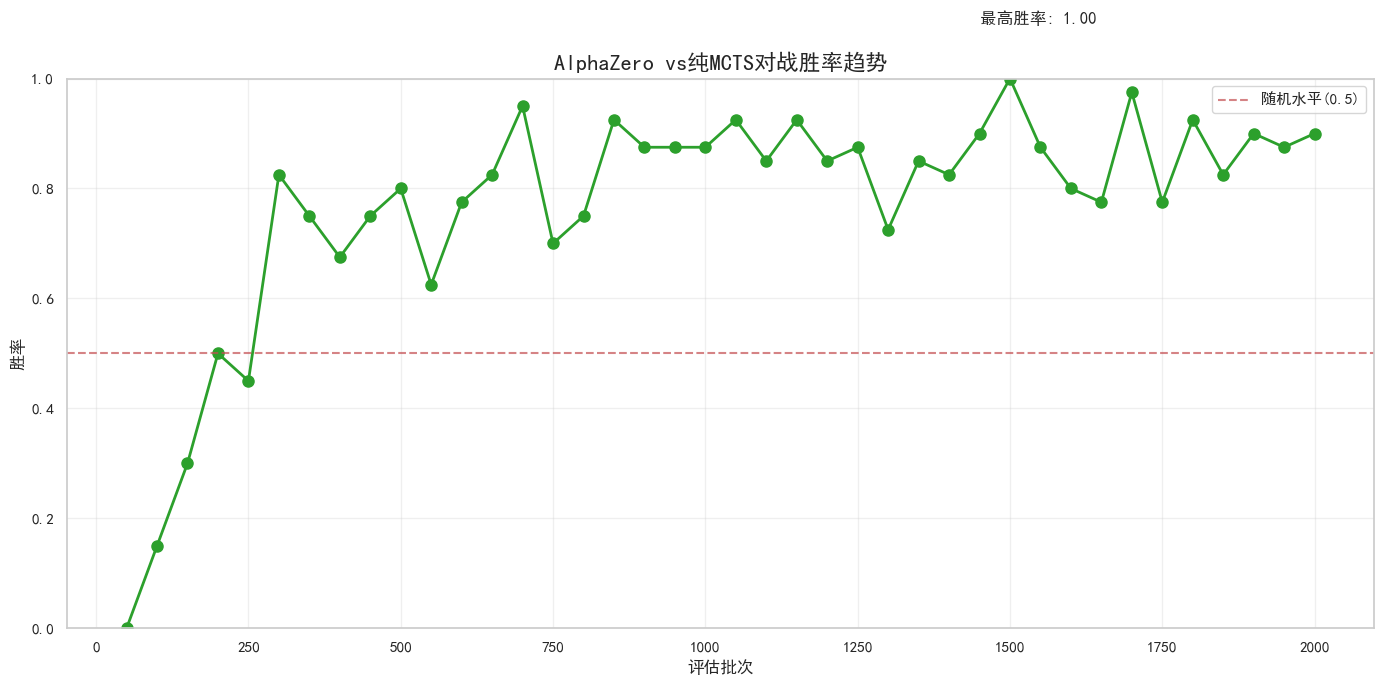

In [10]:
#胜率变化趋势
plt.figure(figsize=(14, 7))

plt.plot(eval_df['eval_batch'], eval_df['win_ratio'], color='tab:green', marker='o', linestyle='-', linewidth=2, markersize=8)
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.7, label='随机水平(0.5)')

plt.xlabel('评估批次')
plt.ylabel('胜率')
plt.title('AlphaZero vs纯MCTS对战胜率趋势', fontsize=16)
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.legend()

# 添加注释，标记胜率最高点
max_idx = eval_df['win_ratio'].idxmax()
max_batch = eval_df.loc[max_idx, 'eval_batch']
max_wr = eval_df.loc[max_idx, 'win_ratio']
plt.annotate(f'最高胜率: {max_wr:.2f}',
             xy=(max_batch, max_wr), xycoords='data',
             xytext=(max_batch-50, max_wr+0.1), textcoords='data',
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"), 
             fontsize=12)

plt.tight_layout()
plt.savefig('win_ratio_trend.png', dpi=300, bbox_inches='tight')
plt.show()

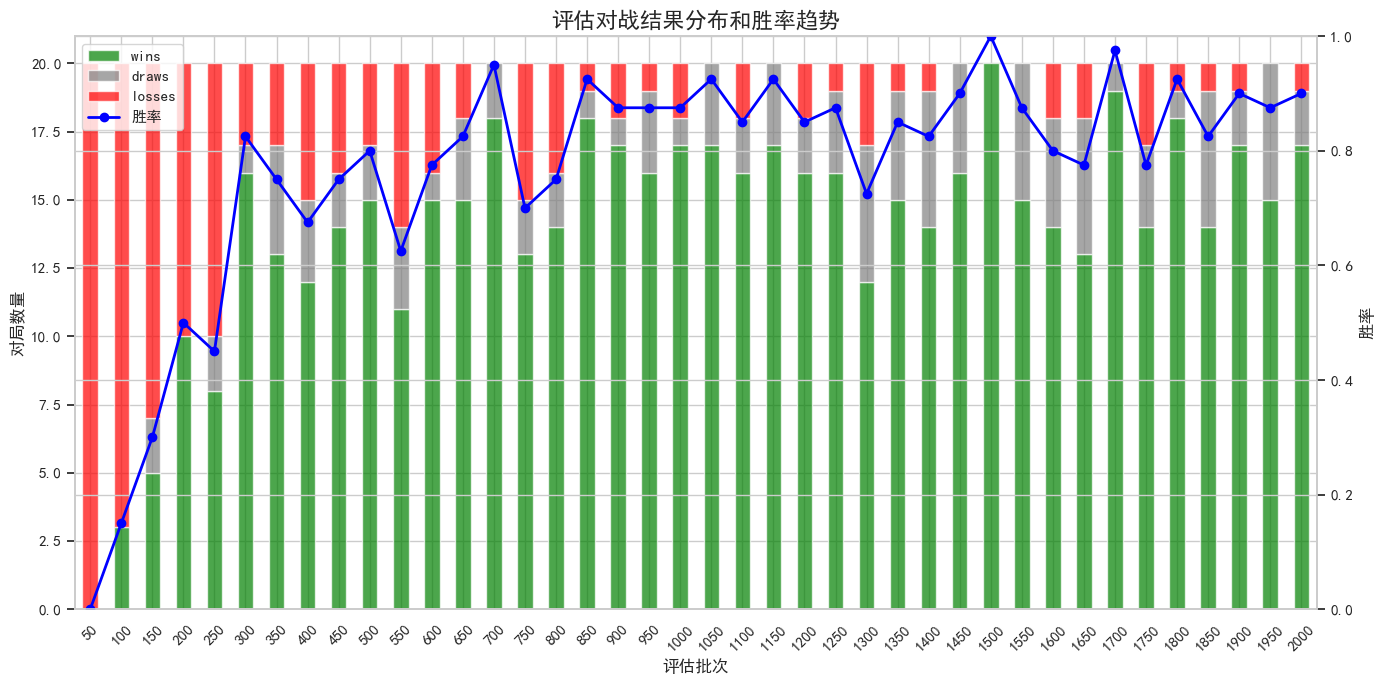

In [11]:
# 胜负平分布堆积图
fig, ax = plt.subplots(figsize=(14, 7))

#堆积柱状图显示胜、负、平的分布
eval_df.plot(x='eval_batch', y=['wins', 'draws', 'losses'], kind='bar', stacked=True, 
             color=['green', 'gray', 'red'], ax=ax, alpha=0.7)

# 在同一图上添加胜率线
ax2 = ax.twinx()
ax2.plot(range(len(eval_df)), eval_df['win_ratio'], color='blue', marker='o', linestyle='-', linewidth=2, label='胜率')

# 设置图表标题和标签
ax.set_title('评估对战结果分布和胜率趋势', fontsize=16)
ax.set_xlabel('评估批次')
ax.set_ylabel('对局数量')
ax2.set_ylabel('胜率')

# 设置X轴标签为评估批次
ax.set_xticklabels(eval_df['eval_batch'], rotation=45)
ax2.set_ylim(0, 1)

# 组合两个图例
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.savefig('evaluation_results_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. 关键指标相关性分析

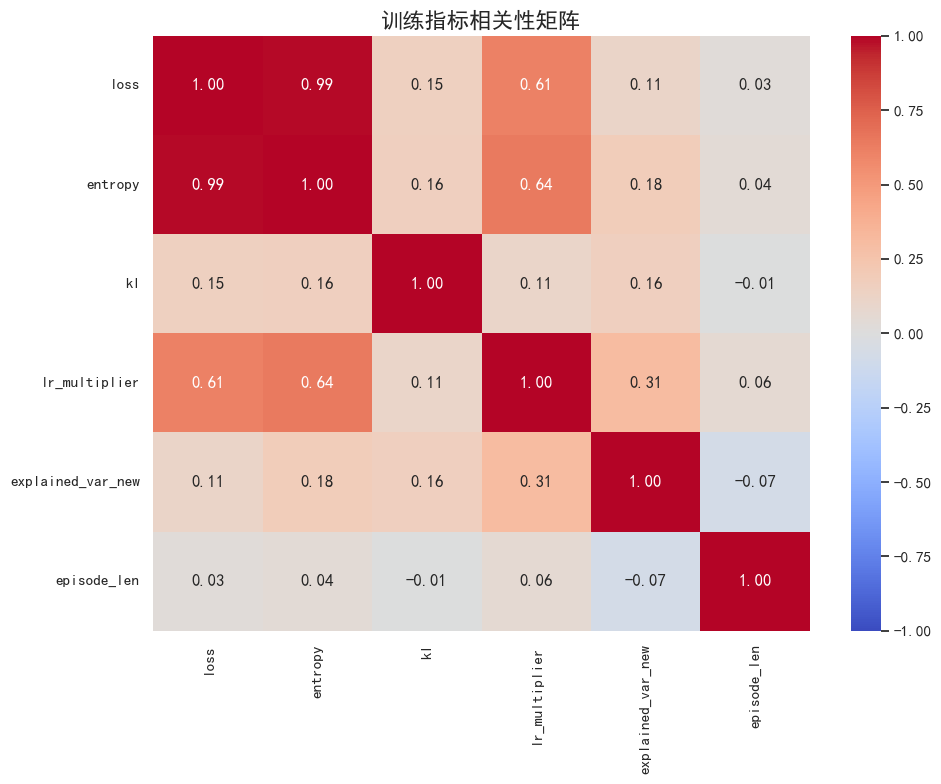

In [12]:
# 训练指标相关性热力图
plt.figure(figsize=(10, 8))
corr_matrix = train_df[['loss', 'entropy', 'kl', 'lr_multiplier', 'explained_var_new', 'episode_len']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('训练指标相关性矩阵', fontsize=16)
plt.tight_layout()
plt.savefig('training_metrics_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# 合并训练和评估数据，分析一些关键指标与胜率的关系
# 注意：这里我们需要对训练数据做一些处理，因为评估不是每批次都进行的

# 创建合并后的DataFrame用于分析
merged_data = pd.DataFrame()

# 对于每个评估批次，找到最接近的训练数据点
for _, eval_row in eval_df.iterrows():
    eval_batch = eval_row['eval_batch']
    
    # 找最接近评估批次的训练数据
    closest_train = train_df.iloc[(train_df['batch'] - eval_batch).abs().argsort()[0]]
    
    # 合并评估和训练数据
    data = {
        'batch': eval_batch,
        'win_ratio': eval_row['win_ratio'],
        'loss': closest_train['loss'],
        'entropy': closest_train['entropy'],
        'kl': closest_train['kl'],
        'explained_var_new': closest_train['explained_var_new']
    }
    
    merged_data = pd.concat([merged_data, pd.DataFrame([data])], ignore_index=True)

# 计算胜率与各指标的相关系数
correlations = {}
for column in ['loss', 'entropy', 'kl', 'explained_var_new']:
    correlation, p_value = stats.pearsonr(merged_data['win_ratio'], merged_data[column])
    correlations[column] = (correlation, p_value)

# 显示结果
for metric, (corr, p_val) in correlations.items():
    significance = "显著" if p_val < 0.05 else "不显著"
    print(f"胜率与{metric}的相关性: {corr:.4f} (p={p_val:.4f}, {significance})")

胜率与loss的相关性: -0.9102 (p=0.0000, 显著)
胜率与entropy的相关性: -0.9062 (p=0.0000, 显著)
胜率与kl的相关性: -0.5411 (p=0.0003, 显著)
胜率与explained_var_new的相关性: -0.0691 (p=0.6720, 不显著)


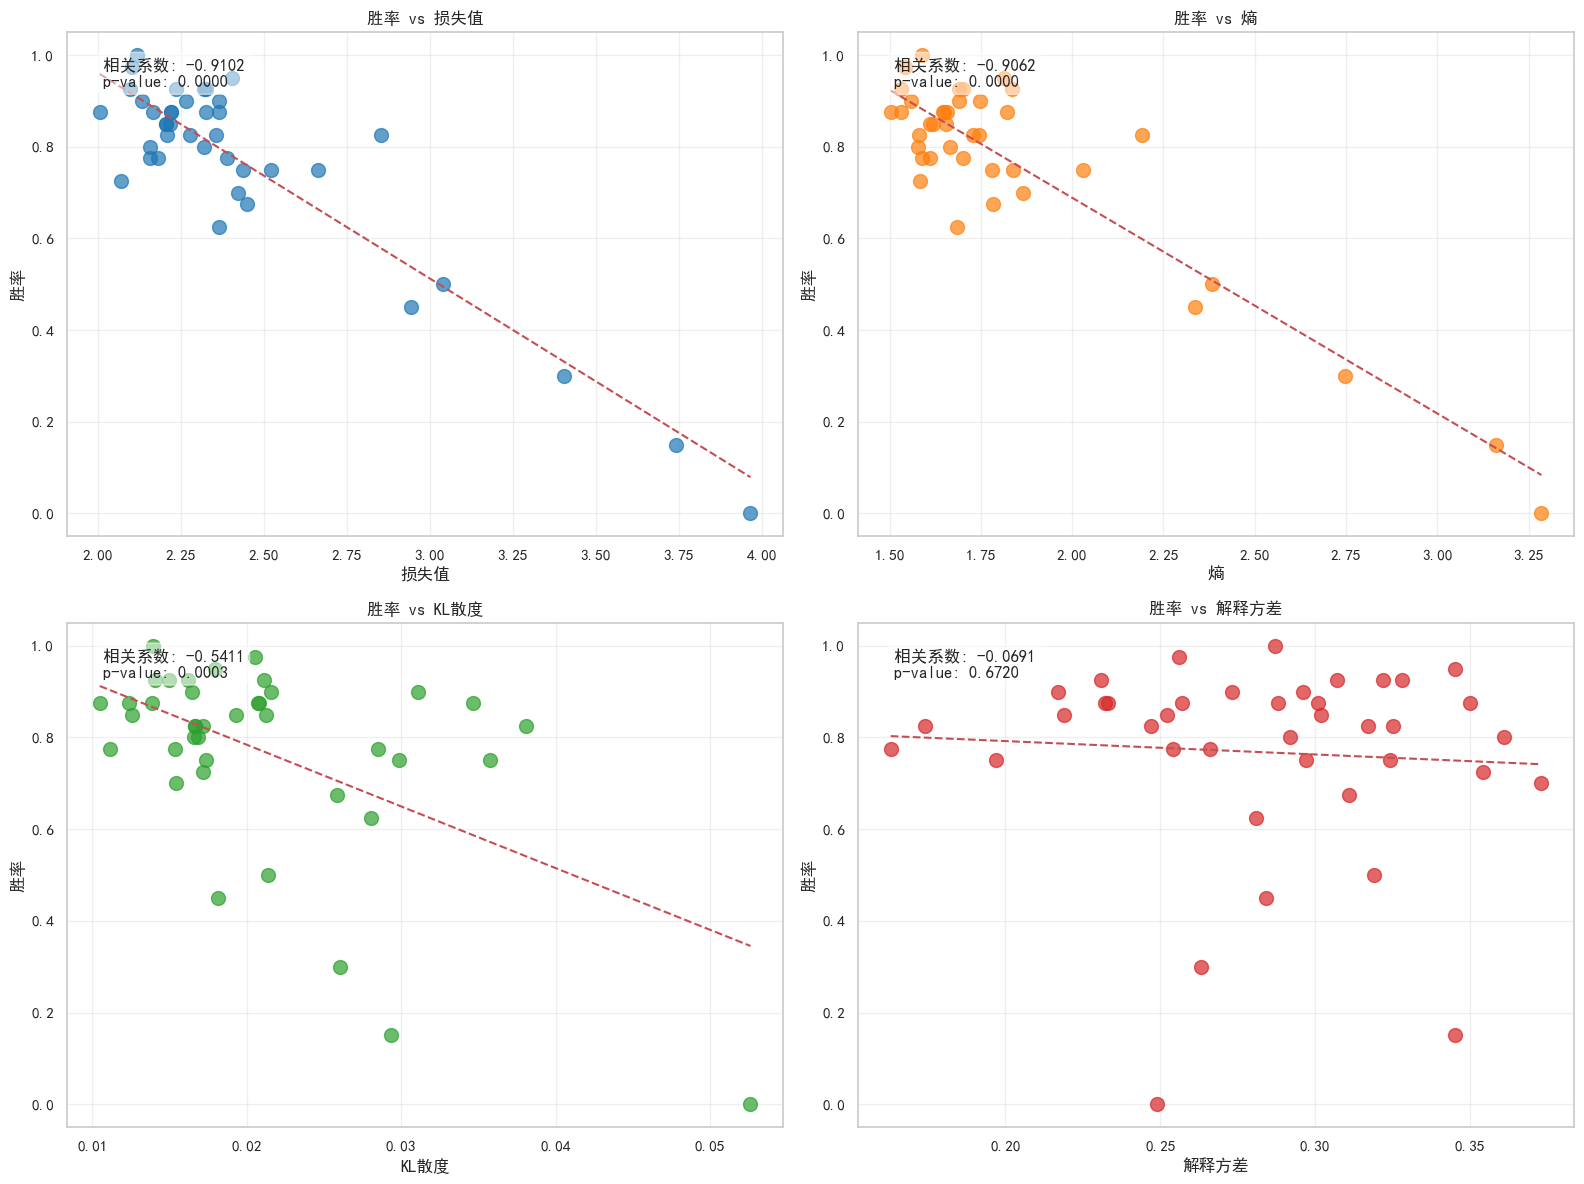

In [14]:
#胜率与关键指标散点图
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

metrics = ['loss', 'entropy', 'kl', 'explained_var_new']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
titles = ['损失值', '熵','KL散度', '解释方差']

for i, (metric, color, title) in enumerate(zip(metrics, colors, titles)):
    axes[i].scatter(merged_data[metric], merged_data['win_ratio'], color=color, alpha=0.7, s=100)
    
    # 添加趋势线
    z = np.polyfit(merged_data[metric], merged_data['win_ratio'], 1)
    p = np.poly1d(z)
    x_range = np.linspace(min(merged_data[metric]), max(merged_data[metric]), 100)
    axes[i].plot(x_range, p(x_range), 'r--')
    
    # 显示相关系数
    corr, p_val = correlations[metric]
    axes[i].text(0.05, 0.95, f"相关系数: {corr:.4f}\np-value: {p_val:.4f}", 
                transform=axes[i].transAxes, fontsize=12,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    axes[i].set_xlabel(title)
    axes[i].set_ylabel('胜率')
    axes[i].set_title(f'胜率 vs {title}')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('win_ratio_vs_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. 训练进度与稳定性分析

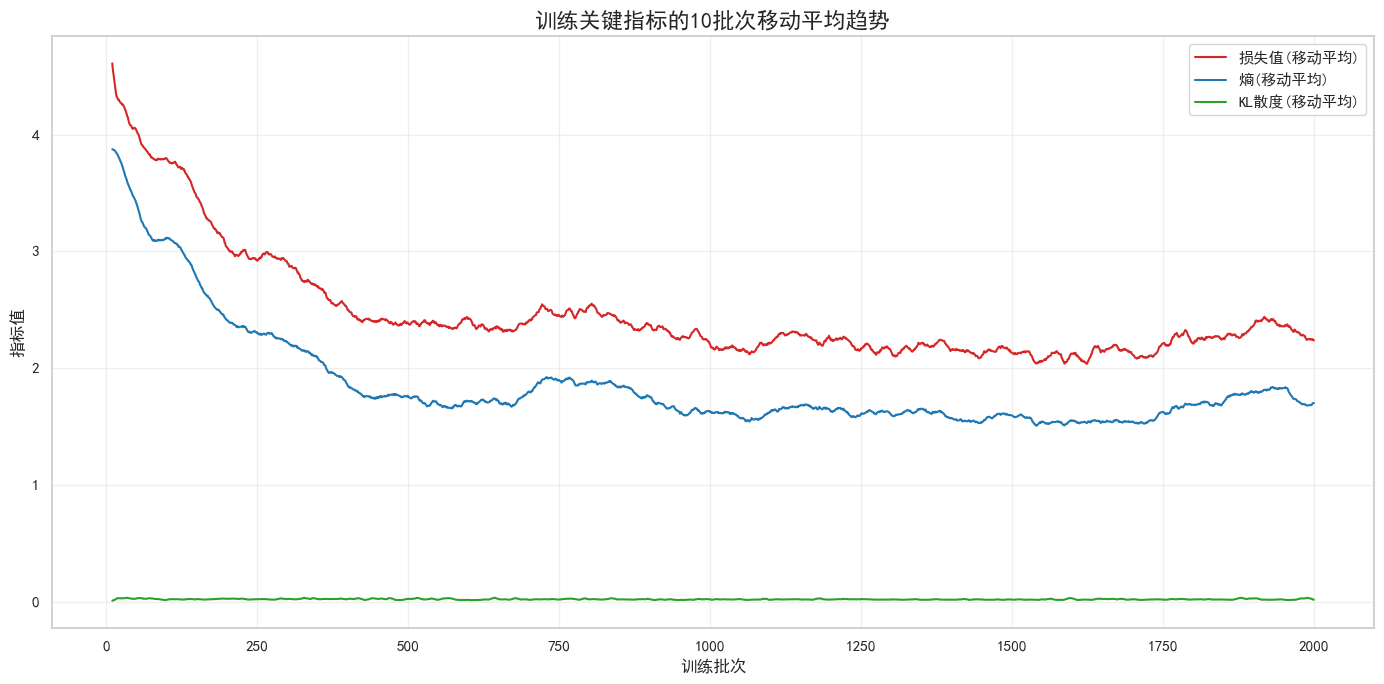

In [15]:
# 计算关键指标的移动平均，用于观察趋势更平滑的变化
window_size = 10  # 移动平均窗口大小

if len(train_df) > window_size:
    train_df['loss_ma'] = train_df['loss'].rolling(window=window_size).mean()
    train_df['entropy_ma'] = train_df['entropy'].rolling(window=window_size).mean()
    train_df['kl_ma'] = train_df['kl'].rolling(window=window_size).mean()

    plt.figure(figsize=(14, 7))

    plt.plot(train_df['batch'], train_df['loss_ma'], color='tab:red', label='损失值(移动平均)')
    plt.plot(train_df['batch'], train_df['entropy_ma'], color='tab:blue', label='熵(移动平均)')
    plt.plot(train_df['batch'], train_df['kl_ma'], color='tab:green', label='KL散度(移动平均)')

    plt.xlabel('训练批次')
    plt.ylabel('指标值')
    plt.title(f'训练关键指标的{window_size}批次移动平均趋势', fontsize=16)
    plt.grid(True, alpha=0.3)
    #plt.legen
    plt.legend()

    plt.tight_layout()
    plt.savefig('metrics_moving_average.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print(f"训练数据点不足{window_size}个，无法计算移动平均。")

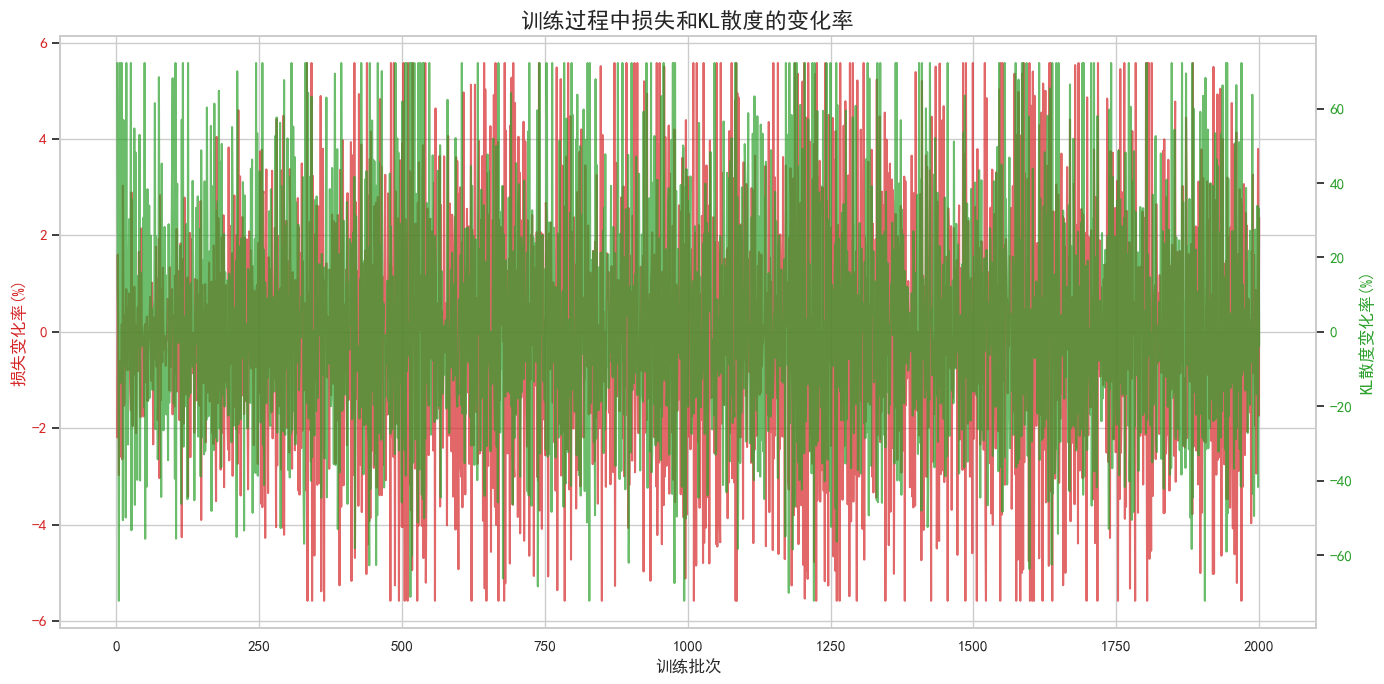

损失值变化率标准差: 2.64%
KL散度变化率标准差: 31.35%
损失值平均绝对变化率: 2.11%
KL散度平均绝对变化率: 25.01%


In [16]:
# 计算KL散度和损失的变化率，分析训练稳定性
if len(train_df) > 1:
    train_df['loss_change'] = train_df['loss'].pct_change() * 100  # 百分比变化
    train_df['kl_change'] = train_df['kl'].pct_change() * 100

    # 去掉第一行（因为变化率计算会产生NaN）和过大的值
    change_df = train_df.iloc[1:].copy()
    # 限制变化率范围，便于可视化
    loss_upper = np.percentile(change_df['loss_change'].abs(), 95)
    kl_upper = np.percentile(change_df['kl_change'].abs(), 95)
    change_df.loc[change_df['loss_change'] > loss_upper, 'loss_change'] = loss_upper
    change_df.loc[change_df['loss_change'] < -loss_upper, 'loss_change'] = -loss_upper
    change_df.loc[change_df['kl_change'] > kl_upper, 'kl_change'] = kl_upper
    change_df.loc[change_df['kl_change'] < -kl_upper, 'kl_change'] = -kl_upper

    fig, ax1 = plt.subplots(figsize=(14, 7))

    color = 'tab:red'
    ax1.set_xlabel('训练批次')
    ax1.set_ylabel('损失变化率(%)', color=color)
    ax1.plot(change_df['batch'], change_df['loss_change'], color=color, marker='', linestyle='-', alpha=0.7)
    ax1.tick_params(axis='y', labelcolor=color)

    # 创建第二个Y轴
    ax2 = ax1.twinx()  
    color = 'tab:green'
    ax2.set_ylabel('KL散度变化率(%)', color=color)  
    ax2.plot(change_df['batch'], change_df['kl_change'], color=color, marker='', linestyle='-', alpha=0.7)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('训练过程中损失和KL散度的变化率', fontsize=16)
    plt.grid(False)

    plt.tight_layout()
    plt.savefig('metrics_change_rate.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 计算稳定性指标：变化率的标准差和平均绝对值
    loss_stability = change_df['loss_change'].std()
    kl_stability = change_df['kl_change'].std()
    loss_avg_change = change_df['loss_change'].abs().mean()
    kl_avg_change = change_df['kl_change'].abs().mean()
    
    print(f"损失值变化率标准差: {loss_stability:.2f}%")
    print(f"KL散度变化率标准差: {kl_stability:.2f}%")
    print(f"损失值平均绝对变化率: {loss_avg_change:.2f}%")
    print(f"KL散度平均绝对变化率: {kl_avg_change:.2f}%")
else:
    print("训练数据点不足，无法计算变化率。")

## 6. 培训性能阶段分析

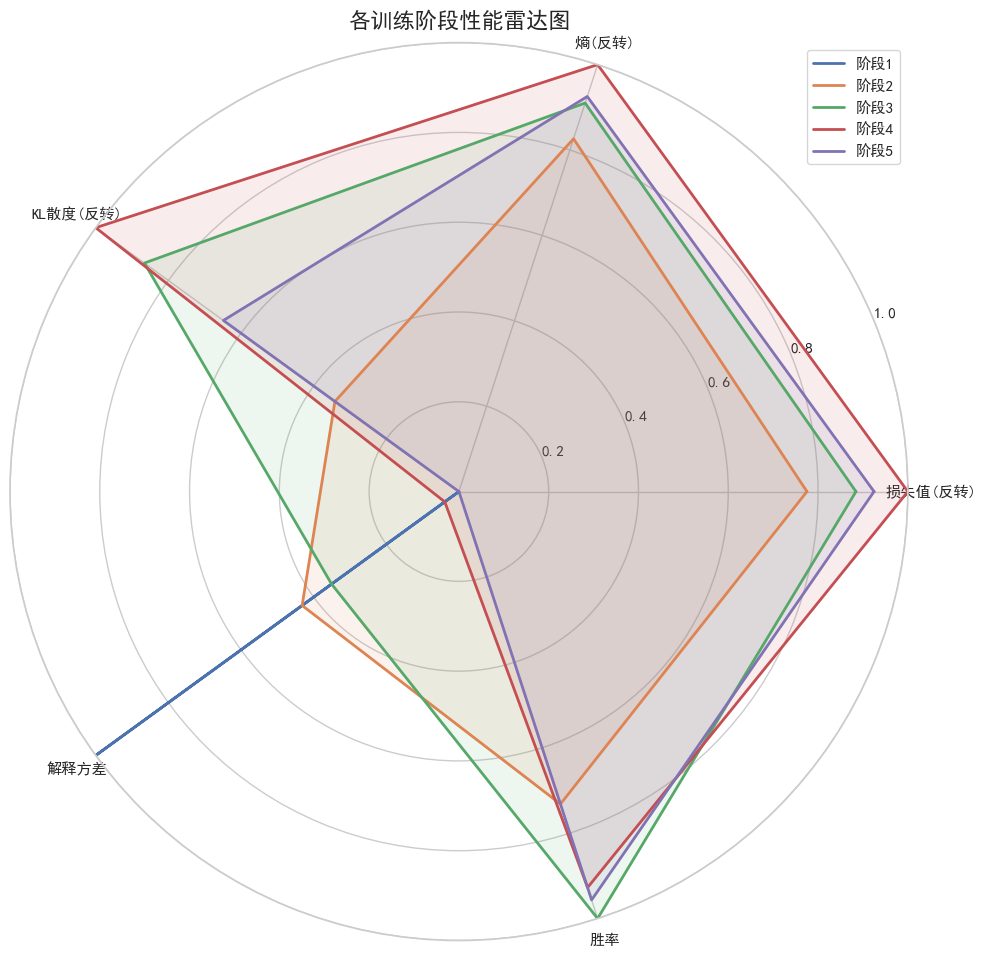

,stage,loss,entropy,kl,explained_var_new,win_ratio
0,1,3.271139,2.622404,0.023096,0.303957,0.456250
1,2,2.405439,1.768279,0.021707,0.281270,0.771875
2,3,2.283546,1.681766,0.019573,0.278033,0.887500
3,4,2.154534,1.588758,0.019028,0.265590,0.856250
4,5,2.238572,1.665924,0.020458,0.264035,0.868750


In [17]:
# 将整个训练过程分为多个阶段，分析各阶段的性能变化
if len(train_df) > 50 and len(eval_df) > 3:  # 确保有足够数据点进行分段分析
    # 定义训练阶段 (每个阶段包含相同数量的批次)
    num_stages = min(5, len(eval_df)) # 分为5个阶段或更少
    max_batch = train_df['batch'].max()
    stage_size = max_batch // num_stages
    
    # 添加阶段标签到训练数据
    train_df['stage'] = (train_df['batch'] - 1) // stage_size + 1
    train_df['stage'] = train_df['stage'].clip(upper=num_stages)  # 确保不超过阶段数
    
    # 对于评估数据，也添加阶段标签
    eval_df['stage'] = (eval_df['eval_batch'] - 1) // stage_size + 1
    eval_df['stage'] = eval_df['stage'].clip(upper=num_stages)
    
    # 按阶段统计平均指标
    stage_metrics = train_df.groupby('stage').agg({
        'loss': 'mean',
        'entropy': 'mean',
        'kl': 'mean',
        'explained_var_new': 'mean',
    }).reset_index()
    
    # 合并评估结果
    stage_eval = eval_df.groupby('stage')['win_ratio'].mean().reset_index()
    stage_metrics = pd.merge(stage_metrics, stage_eval, on='stage')
    
    # 绘制阶段性能雷达图
    metrics = ['loss', 'entropy', 'kl', 'explained_var_new', 'win_ratio']
    
    # 标准化指标值到[0,1]区间，便于比较
    for metric in metrics:
        if metric != 'win_ratio' and metric != 'explained_var_new':  # 这些指标越小越好
            max_val = stage_metrics[metric].max()
            min_val = stage_metrics[metric].min()
            if max_val > min_val:
                stage_metrics[f'{metric}_scaled'] = 1 - (stage_metrics[metric] - min_val) / (max_val - min_val)
            else:
                stage_metrics[f'{metric}_scaled'] = 0.5
        else:  # 这些指标越大越好
            max_val = stage_metrics[metric].max()
            min_val = stage_metrics[metric].min()
            if max_val > min_val:
                stage_metrics[f'{metric}_scaled'] = (stage_metrics[metric] - min_val) / (max_val - min_val)
            else:
                stage_metrics[f'{metric}_scaled'] = 0.5
    
    # 创建雷达图
    labels = ['损失值(反转)', '熵(反转)', 'KL散度(反转)', '解释方差', '胜率']
    scaled_metrics = [f'{m}_scaled' for m in metrics]
    
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]  # 闭合雷达图
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    for i, stage in enumerate(stage_metrics['stage']):
        values = stage_metrics.loc[i, scaled_metrics].tolist()
        values += values[:1]  # 闭合雷达图
        
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'阶段{stage}')
        ax.fill(angles, values, alpha=0.1)
    
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_ylim(0, 1)
    ax.set_title('各训练阶段性能雷达图', fontsize=16)
    plt.legend(loc='upper right')
    
    plt.tight_layout()
    plt.savefig('training_stages_radar.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 表格显示各阶段原始数据
    display(stage_metrics[['stage', 'loss', 'entropy', 'kl', 'explained_var_new', 'win_ratio']])
else:
    print("训练数据点不足，无法进行阶段分析。")

## 7. 训练洞察与建议

基于以上分析，我们可以得出以下洞察与建议：

### 训练进度评估

1. **模型收敛情况**：通过损失、熵和KL散度的下降趋势可以评估模型是否收敛。
   
2. **胜率表现**：通过对战纯MCTS的胜率可以直接评估模型的实战能力提升。

3. **学习效率**：自适应学习率乘数的变化表明了训练的自我调节能力。

### 改进建议

1. **评估对战次数**：目前评估对战为10局，这个样本量偏小容易受随机性影响。建议增加到30-50局以获得更稳定的评估结果。在`config.py`中可以调整评估局数。

2. **训练稳定性**：如果KL散度波动较大，可以考虑降低初始学习率或调整其上下限，提高训练稳定性。

3. **训练扩展**：
   - 考虑在更大的棋盘上训练（如8x8或10x10）
   - 增加MCTS模拟次数以提高策略质量
   - 尝试不同的网络结构

4. **模型评估**：
   - 增加与其他算法的对比评估（如Minimax、Alpha-Beta等）
   - 测试在不同参数设置下模型的表现
   - 人类测试者评估不同阶段模型的质量感受

5. **数据增强**：考虑引入更丰富的数据增强策略，不仅是旋转和翻转。

### 关键发现

1. **自我对弈质量**：随着训练进行，自我对弈的质量通常会提高，游戏长度可能会有变化趋势，反映了策略的成熟度。

2. **解释方差提升**：解释方差的提升反映了价值网络预测准确性的提高，这对MCTS搜索效率至关重要。

3. **熵下降**：策略熵的下降表明模型对动作选择的确定性增强，但过早的熵下降也可能导致探索不足。

根据以上分析，可以对训练参数进行针对性调整，提高模型训练效率和最终性能。

## 8. 结论

通过对AlphaZero五子棋训练日志的全面分析，我们可以看到模型训练的完整过程和性能演变。关键结论如下：

1. **训练趋势**：从损失、熵和KL散度的变化趋势来看，模型整体呈现出逐步收敛的特征。

2. **模型能力**：通过与纯MCTS的对战胜率，我们可以直观地评估模型能力的提升。胜率的稳定提高表明神经网络确实提升了决策质量。

3. **训练稳定性**：学习率自适应调整机制有效地维持了训练稳定性，避免了过大的策略更新。

4. **关键指标关联**：解释方差与胜率的正相关表明价值网络的预测准确性对最终对弈表现有重要影响。

总体而言，训练日志分析提供了丰富的信息，帮助我们理解AlphaZero训练过程中的各种现象，为进一步优化训练策略提供了重要依据。